# IOU/AFL Plots for Different Model Architectures

We find that the results are consistent for different model architecture: as model reasoning gets more complex, acute failure modes are revealed for all methods.

In [61]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import smerf
from smerf.models import *
from smerf.textbox_data import *
from smerf.eval import *
import smerf.explanations as saliency
import pickle
import os
import glob
   
exp_no = 2.11
methods_name =  os.path.join(CACHE_DIR, 'methods_%0.2f.pkl'%exp_no)
methods = pickle.load(open(methods_name, 'rb'))
methods = [m[3] for m in methods][1:]

bar_fig = dict(lw=3, capsize=3, capthick=3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## VGG Results

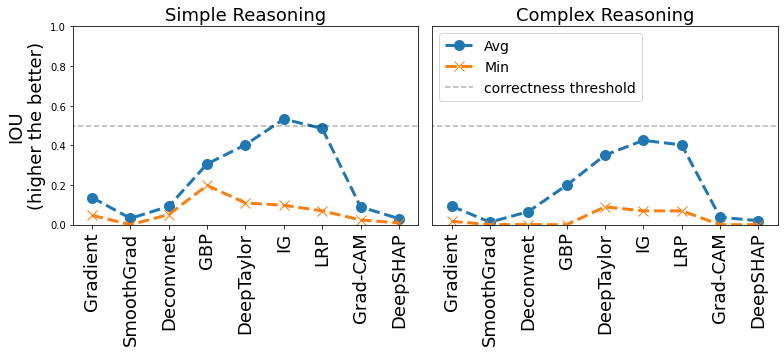

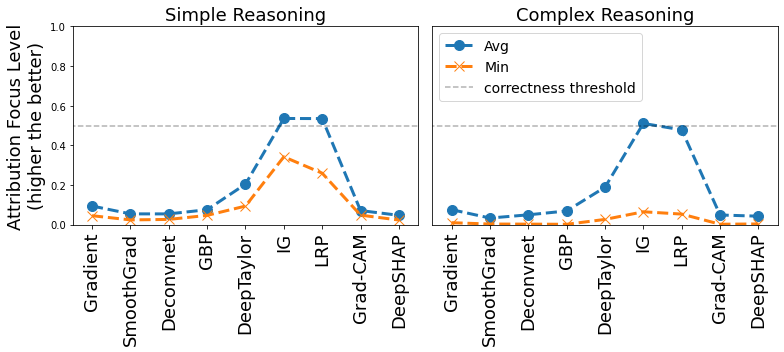

In [68]:
# NOTE Set up the directory for VGG
CACHE_DIR = '../outputs_vgg/cache'
if not os.path.exists(CACHE_DIR):
    os.mkdir(CACHE_DIR)
    
PLOT_DIR = '../outputs_vgg/plots'
if not os.path.exists(PLOT_DIR):
    os.mkdir(PLOT_DIR)
    
import glob
method_idx = [0, 1, 2, 3, 4, 6, 8, 13, 14]
methods_sel = [methods[i] for i in method_idx]
methods_sel = [methods[i] for i in method_idx]
methods_sel = ['Gradient', 
'SmoothGrad',
 'Deconvnet',
 'GBP',
 'DeepTaylor',
 'IG',
 'LRP',
 'Grad-CAM',
 'DeepSHAP',]
simple_case_nos = [1.11,2.11]
complex_case_nos = [1.2, 3.71, 3.72, 3.73, 3.74]

def compute_valid_minmaxavg(arr):
    # ignore invalid ones and compute avg and std
    no_images, no_methods, no_values = arr.shape
    out = []
    for i in range(no_values):
        tt = arr[:,:,i]
        tt = tt[~(tt == -1).any(axis=1)]
        out.append((np.mean(tt, axis=0), np.std(tt, axis=0), np.min(tt,axis=0), np.max(tt,axis=0)))
    return out
 
metric_type = 'plain_single' # results for plain IOU
p_results = []
s_results = []
for s in simple_case_nos:
    bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_*.npy"%(metric_type, s))))
    ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
    for i in ids:
        d = np.load(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_%d.npy"%(metric_type, s,i)))
        bucket_p, bucket_s = d[0], d[2]
        if not np.isnan(bucket_p[0]):
            p_results.append(bucket_p)
        if not np.isnan(bucket_s[0]):
            s_results.append(bucket_s)
p_results = np.array(p_results)
s_results = np.array(s_results)
simple_avg = np.mean(p_results, axis=0)[method_idx]
simple_min = np.min(p_results, axis=0)[method_idx]

p_results = []
s_results = []
for s in complex_case_nos:
    bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_*.npy"%(metric_type, s))))
    ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
    for i in ids:
        d = np.load(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_%d.npy"%(metric_type, s,i)))
        bucket_p, bucket_s = d[0], d[2]
        if not np.isnan(bucket_p[0]):
            p_results.append(bucket_p)
        if not np.isnan(bucket_s[0]):
            s_results.append(bucket_s)
p_results = np.array(p_results)
s_results = np.array(s_results)
complex_avg = np.mean(p_results, axis=0)[method_idx]
complex_min = np.min(p_results, axis=0)[method_idx]

fig, axs = plt.subplots(1,2, figsize=(11,5))
axs[0].plot(simple_avg, '--', marker='o', markersize=10, label='Avg', linewidth=3)
axs[0].plot(simple_min, '--', marker='x', markersize=10, label='Min', linewidth=3)
axs[0].plot([-1, 9], [0.5,0.5], 'k--', alpha=0.3,  label='0.5 threshold')
axs[0].set_ylim([0, 1.0])
axs[0].set_xlim([-0.5, 8.5])
axs[0].set(xticks=[0,1,2,3,4,5,6,7,8], xticklabels=methods_sel)
axs[0].set_xticklabels(methods_sel, rotation=90, fontsize=18)
axs[0].set_title('Simple Reasoning', fontsize=18)
if metric_type == 'plain_single':
    axs[0].set_ylabel('IOU\n(higher the better)', fontsize=18)
elif metric_type == 'afl':
    axs[0].set_ylabel('Attribution Focus Level\n(higher the better)', fontsize=18)

axs[1].plot(complex_avg,  '--', marker='o', markersize=10,label='Avg', linewidth=3)
axs[1].plot(complex_min, '--', marker='x', markersize=10,label='Min', linewidth=3)
axs[1].plot([-1, 9], [0.5,0.5], 'k--', alpha=0.3, label='correctness threshold')
axs[1].set_ylim([0, 1.0])
axs[1].set_yticks(())
axs[1].set_xlim([-0.5, 8.5])
axs[1].set(xticks=[0,1,2,3,4,5,6,7,8], xticklabels=methods_sel)
axs[1].set_xticklabels(methods_sel, rotation=90, fontsize=18)
axs[1].legend(fontsize=14, loc='upper left')
axs[1].set_title('Complex Reasoning', fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'result_main_buckets_%s.pdf'%(metric_type)), dpi=200)

metric_type = 'weighted' # results for AFL
p_results = []
s_results = []
for s in simple_case_nos:
    bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_*.npy"%(metric_type, s))))
    ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
    for i in ids:
        d = np.load(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_%d.npy"%(metric_type, s,i)))
        bucket_p, bucket_s = d[0], d[2]
        if not np.isnan(bucket_p[0]):
            p_results.append(bucket_p)
        if not np.isnan(bucket_s[0]):
            s_results.append(bucket_s)
p_results = np.array(p_results)
s_results = np.array(s_results)
simple_avg = np.mean(p_results, axis=0)[method_idx]
simple_min = np.min(p_results, axis=0)[method_idx]
simple_avg = np.nan_to_num(simple_avg)
simple_min = np.nan_to_num(simple_min)

p_results = []
s_results = []
for s in complex_case_nos:
    bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_*.npy"%(metric_type, s))))
    ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
    for i in ids:
        d = np.load(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_%d.npy"%(metric_type, s,i)))
        bucket_p, bucket_s = d[0], d[2]
        if not np.isnan(bucket_p[0]):
            p_results.append(bucket_p)
        if not np.isnan(bucket_s[0]):
            s_results.append(bucket_s)
p_results = np.array(p_results)
s_results = np.array(s_results)
complex_avg = np.mean(p_results, axis=0)[method_idx]
complex_min = np.min(p_results, axis=0)[method_idx]
complex_avg = np.nan_to_num(complex_avg)
complex_min = np.nan_to_num(complex_min)

fig, axs = plt.subplots(1,2, figsize=(11,5))
axs[0].plot(simple_avg, '--', marker='o', markersize=10, label='Avg', linewidth=3)
axs[0].plot(simple_min, '--', marker='x', markersize=10, label='Min', linewidth=3)
axs[0].plot([-1, 9], [0.5,0.5], 'k--', alpha=0.3,  label='0.5 threshold')
axs[0].set_ylim([0, 1.0])
axs[0].set_xlim([-0.5, 8.5])
axs[0].set(xticks=[0,1,2,3,4,5,6,7,8], xticklabels=methods_sel)
axs[0].set_xticklabels(methods_sel, rotation=90, fontsize=18)
axs[0].set_title('Simple Reasoning', fontsize=18)
if metric_type == 'plain_single':
    axs[0].set_ylabel('IOU\n(higher the better)', fontsize=18)
elif metric_type == 'weighted':
    axs[0].set_ylabel('Attribution Focus Level\n(higher the better)', fontsize=18)

axs[1].plot(complex_avg,  '--', marker='o', markersize=10,label='Avg', linewidth=3)
axs[1].plot(complex_min, '--', marker='x', markersize=10,label='Min', linewidth=3)
axs[1].plot([-1, 9], [0.5,0.5], 'k--', alpha=0.3, label='correctness threshold')
axs[1].set_ylim([0, 1.0])
axs[1].set_yticks(())
axs[1].set_xlim([-0.5, 8.5])
axs[1].set(xticks=[0,1,2,3,4,5,6,7,8], xticklabels=methods_sel)
axs[1].set_xticklabels(methods_sel, rotation=90, fontsize=18)
axs[1].legend(fontsize=14, loc='upper left')
axs[1].set_title('Complex Reasoning', fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'result_main_buckets_%s.pdf'%(metric_type)), dpi=200)

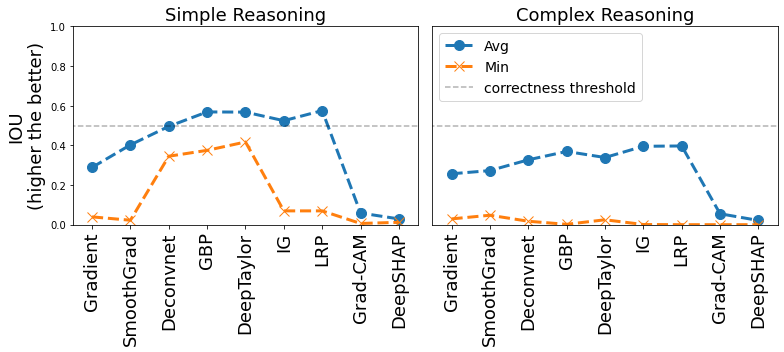

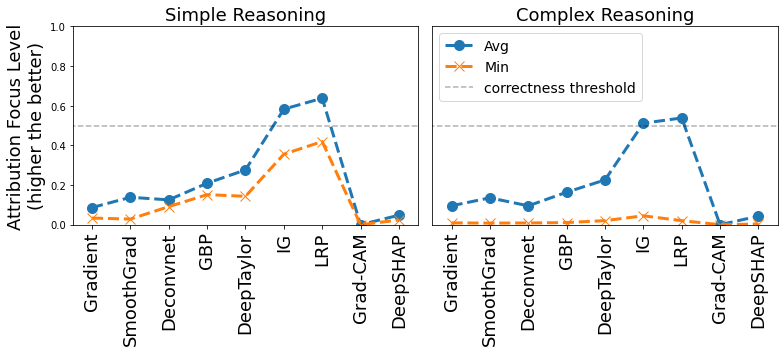

In [69]:
# NOTE Set up the directory for AlexNet
CACHE_DIR = '../outputs_alex/cache'
if not os.path.exists(CACHE_DIR):
    os.mkdir(CACHE_DIR)
    
PLOT_DIR = '../outputs_alex/plots'
if not os.path.exists(PLOT_DIR):
    os.mkdir(PLOT_DIR)
    
metric_type = 'plain_single' # results for plain IOU
p_results = []
s_results = []
for s in simple_case_nos:
    bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_*.npy"%(metric_type, s))))
    ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
    for i in ids:
        d = np.load(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_%d.npy"%(metric_type, s,i)))
        bucket_p, bucket_s = d[0], d[2]
        if not np.isnan(bucket_p[0]):
            p_results.append(bucket_p)
        if not np.isnan(bucket_s[0]):
            s_results.append(bucket_s)
p_results = np.array(p_results)
s_results = np.array(s_results)
simple_avg = np.mean(p_results, axis=0)[method_idx]
simple_min = np.min(p_results, axis=0)[method_idx]

p_results = []
s_results = []
for s in complex_case_nos:
    bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_*.npy"%(metric_type, s))))
    ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
    for i in ids:
        d = np.load(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_%d.npy"%(metric_type, s,i)))
        bucket_p, bucket_s = d[0], d[2]
        if not np.isnan(bucket_p[0]):
            p_results.append(bucket_p)
        if not np.isnan(bucket_s[0]):
            s_results.append(bucket_s)
p_results = np.array(p_results)
s_results = np.array(s_results)
complex_avg = np.mean(p_results, axis=0)[method_idx]
complex_min = np.min(p_results, axis=0)[method_idx]

fig, axs = plt.subplots(1,2, figsize=(11,5))
axs[0].plot(simple_avg, '--', marker='o', markersize=10, label='Avg', linewidth=3)
axs[0].plot(simple_min, '--', marker='x', markersize=10, label='Min', linewidth=3)
axs[0].plot([-1, 9], [0.5,0.5], 'k--', alpha=0.3,  label='0.5 threshold')
axs[0].set_ylim([0, 1.0])
axs[0].set_xlim([-0.5, 8.5])
axs[0].set(xticks=[0,1,2,3,4,5,6,7,8], xticklabels=methods_sel)
axs[0].set_xticklabels(methods_sel, rotation=90, fontsize=18)
axs[0].set_title('Simple Reasoning', fontsize=18)
if metric_type == 'plain_single':
    axs[0].set_ylabel('IOU\n(higher the better)', fontsize=18)
elif metric_type == 'afl':
    axs[0].set_ylabel('Attribution Focus Level\n(higher the better)', fontsize=18)

axs[1].plot(complex_avg,  '--', marker='o', markersize=10,label='Avg', linewidth=3)
axs[1].plot(complex_min, '--', marker='x', markersize=10,label='Min', linewidth=3)
axs[1].plot([-1, 9], [0.5,0.5], 'k--', alpha=0.3, label='correctness threshold')
axs[1].set_ylim([0, 1.0])
axs[1].set_yticks(())
axs[1].set_xlim([-0.5, 8.5])
axs[1].set(xticks=[0,1,2,3,4,5,6,7,8], xticklabels=methods_sel)
axs[1].set_xticklabels(methods_sel, rotation=90, fontsize=18)
axs[1].legend(fontsize=14, loc='upper left')
axs[1].set_title('Complex Reasoning', fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'result_main_buckets_%s.pdf'%(metric_type)), dpi=200)

metric_type = 'weighted' # results for AFL
p_results = []
s_results = []
for s in simple_case_nos:
    bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_*.npy"%(metric_type, s))))
    ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
    for i in ids:
        d = np.load(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_%d.npy"%(metric_type, s,i)))
        bucket_p, bucket_s = d[0], d[2]
        if not np.isnan(bucket_p[0]):
            p_results.append(bucket_p)
        if not np.isnan(bucket_s[0]):
            s_results.append(bucket_s)
p_results = np.array(p_results)
s_results = np.array(s_results)
simple_avg = np.mean(p_results, axis=0)[method_idx]
simple_min = np.min(p_results, axis=0)[method_idx]
simple_avg = np.nan_to_num(simple_avg)
simple_min = np.nan_to_num(simple_min)

p_results = []
s_results = []
for s in complex_case_nos:
    bucket_results = sorted(glob.glob(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_*.npy"%(metric_type, s))))
    ids = sorted([int(x.split('_')[-1][:-4]) for x in bucket_results])
    for i in ids:
        d = np.load(os.path.join(CACHE_DIR, "metrics_%s_%0.2f_%d.npy"%(metric_type, s,i)))
        bucket_p, bucket_s = d[0], d[2]
        if not np.isnan(bucket_p[0]):
            p_results.append(bucket_p)
        if not np.isnan(bucket_s[0]):
            s_results.append(bucket_s)
p_results = np.array(p_results)
s_results = np.array(s_results)
complex_avg = np.mean(p_results, axis=0)[method_idx]
complex_min = np.min(p_results, axis=0)[method_idx]
complex_avg = np.nan_to_num(complex_avg)
complex_min = np.nan_to_num(complex_min)

fig, axs = plt.subplots(1,2, figsize=(11,5))
axs[0].plot(simple_avg, '--', marker='o', markersize=10, label='Avg', linewidth=3)
axs[0].plot(simple_min, '--', marker='x', markersize=10, label='Min', linewidth=3)
axs[0].plot([-1, 9], [0.5,0.5], 'k--', alpha=0.3,  label='0.5 threshold')
axs[0].set_ylim([0, 1.0])
axs[0].set_xlim([-0.5, 8.5])
axs[0].set(xticks=[0,1,2,3,4,5,6,7,8], xticklabels=methods_sel)
axs[0].set_xticklabels(methods_sel, rotation=90, fontsize=18)
axs[0].set_title('Simple Reasoning', fontsize=18)
if metric_type == 'plain_single':
    axs[0].set_ylabel('IOU\n(higher the better)', fontsize=18)
elif metric_type == 'weighted':
    axs[0].set_ylabel('Attribution Focus Level\n(higher the better)', fontsize=18)

axs[1].plot(complex_avg,  '--', marker='o', markersize=10,label='Avg', linewidth=3)
axs[1].plot(complex_min, '--', marker='x', markersize=10,label='Min', linewidth=3)
axs[1].plot([-1, 9], [0.5,0.5], 'k--', alpha=0.3, label='correctness threshold')
axs[1].set_ylim([0, 1.0])
axs[1].set_yticks(())
axs[1].set_xlim([-0.5, 8.5])
axs[1].set(xticks=[0,1,2,3,4,5,6,7,8], xticklabels=methods_sel)
axs[1].set_xticklabels(methods_sel, rotation=90, fontsize=18)
axs[1].legend(fontsize=14, loc='upper left')
axs[1].set_title('Complex Reasoning', fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'result_main_buckets_%s.pdf'%(metric_type)), dpi=200)